In [1]:
import ants
import nilearn
from nilearn import image
import os
import shutil
import nibabel as nib
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from nilearn.image import load_img
from nilearn.image import math_img
from nilearn.image import resample_to_img
from nipype.interfaces.ants import ApplyTransforms
from scipy import stats
from scipy.stats import pearsonr
from scipy.stats import spearmanr

In [ ]:
#converting MNI ROIs to each patient's native space- does not like special characters in paths, like &!!!!
def mni2native(i,hemisphere,hotspot,interpolation='NearestNeighbor'):
    print(f'converting to native for {i} in hotspot {hotspot}')
    at = ApplyTransforms()
    at.inputs.dimension = 3
    at.inputs.input_image = f'/Volumes/Cingulate/NativeMNI_Overlaps/Berlin51/HotspotsAtlas/resampled/{hotspot}_{hemisphere}.nii.gz'
    
    base_path = f'/Volumes/Cingulate/NativeMNI_Overlaps/Berlin51/Data/derivatives/leaddbs/{i}/coregistration/anat/{i}_ses-preop_space-anchorNative_desc-preproc_acq-'
    possible_files = ['ax_T1w.nii', 'cor_T1w.nii', 'iso_T1w.nii', 'ax_T2w.nii', 'iso_T2w.nii', 'sag_T1w.nii']
    
    reference_image = None
    for file_suffix in possible_files:
        ref_image_path = f'{base_path}{file_suffix}'
        if os.path.exists(ref_image_path):
            reference_image = ref_image_path
            break
        
    at.inputs.reference_image = reference_image
    at.inputs.transforms = f'/Volumes/Cingulate/NativeMNI_Overlaps/Berlin51/Data/derivatives/leaddbs/{i}/normalization/transformations/{i}_from-MNI152NLin2009bAsym_to-anchorNative_desc-ants.nii.gz'
    at.inputs.output_image = f'/Volumes/Cingulate/NativeMNI_Overlaps/Berlin51/OSS-DBS/{i}/{i}_{hotspot}_{hemisphere}_native_output.nii'
    at.inputs.invert_transform_flags = [False]
    at.inputs.interpolation = interpolation
    at.run()
    
directory = [i for i in os.listdir('/Volumes/Cingulate/NativeMNI_Overlaps/Berlin51/OSS-DBS') if i.startswith('sub')]
hotspots = ['STN','STN_motor','pd_stn_n275_hotspot']
hemispheres = ['lh','rh']

for i in directory:
    for hotspot in hotspots:
        for hemisphere in hemispheres:
            mni2native(i,hemisphere,hotspot)

In [3]:
#load, check for voxel dimensions, resample
directory = [i for i in os.listdir('/Volumes/Cingulate/NativeMNI_Overlaps/Berlin51/FNIRT/derivatives/leaddbs') if i.startswith('sub-BER020')]

def dim(path):
    return nib.load(path).header.get_zooms()

def resample_binarize(sub,stn,output_path):
    sub = load_img(sub)
    stn = load_img(stn)
    re_sub = resample_to_img(sub,stn,interpolation='nearest')
    nib.save(re_sub,output_path)
    
def check4dims(sub_vox,stn_vox,sub,stn,output_path):
    if sub_vox == stn_vox:
        print('voxel dimensions the same')
    else:
        resample_binarize(sub,stn,output_path)

stn_mni_lh = '/Volumes/Cingulate/NativeMNI_Overlaps/Berlin51/HotspotsAtlas/resampled/STN_lh.nii.gz'
stn_mni_vox_lh = dim(stn_mni_lh)
stn_mni_rh = '/Volumes/Cingulate/NativeMNI_Overlaps/Berlin51/HotspotsAtlas/resampled/STN_rh.nii.gz'
stn_mni_vox_rh = dim(stn_mni_rh)

for i in directory:
    #load in native stn for resampling anchor
#     stn_native = f'/Volumes/Cingulate/NativeMNI_Overlaps/Berlin51/STNs/NativeSTNs/{i}.nii'
#     stn_native_vox = dim(stn_native)
    
    #load in patients
#     native_lh = f'/Volumes/Cingulate/NativeMNI_Overlaps/Berlin51/FNIRT/{i}/stimulations/native/gs_/{i}_sim-binary_model-simbio_hemi-L.nii'
#     native_rh = f'/Volumes/Cingulate/NativeMNI_Overlaps/Berlin51/FNIRT/{i}/stimulations/native/gs_/{i}_sim-binary_model-simbio_hemi-R.nii'
#     native2mni_lh = f'/Volumes/Cingulate/NativeMNI_Overlaps/Berlin51/FieldTrip/{i}/stimulations/native2MNI/MNI152NLin2009bAsym/gs_/{i}_sim-binary_model-simbio_hemi-L.nii'
#     native2mni_rh = f'/Volumes/Cingulate/NativeMNI_Overlaps/Berlin51/FieldTrip/{i}/stimulations/native2MNI/MNI152NLin2009bAsym/gs_/{i}_sim-binary_model-simbio_hemi-R.nii'
    mni_lh = f'/Volumes/Cingulate/NativeMNI_Overlaps/Berlin51/FNIRT/derivatives/leaddbs/{i}/stimulations/MNI152NLin2009bAsym/gs_20241119142431/{i}_sim-binary_model-ossdbs_hemi-L.nii'
    mni_rh = f'/Volumes/Cingulate/NativeMNI_Overlaps/Berlin51/FNIRT/derivatives/leaddbs/{i}/stimulations/MNI152NLin2009bAsym/gs_20241119142431/{i}_sim-binary_model-ossdbs_hemi-R.nii'
    
#     native_lh_sub,native_rh_sub = load_img(native_lh),load_img(native_rh)
#     native2mni_lh_sub,native2mni_rh_sub = load_img(native2mni_lh),load_img(native2mni_rh)
    mni_lh_sub,mni_rh_sub = load_img(mni_lh),load_img(mni_rh)
    
#     native_lh_vox,native_rh_vox = dim(native_lh),dim(native_rh)
#     native2mni_lh_vox,native2mni_rh_vox = dim(native2mni_lh),dim(native2mni_rh)
    mni_lh_vox,mni_rh_vox = dim(mni_lh),dim(mni_rh)
    
#     check4dims(native_lh_vox,stn_native_vox,native_lh_sub,stn_native,f'/Volumes/Cingulate/NativeMNI_Overlaps/Berlin51/OSS-DBS/{i}/resampled/{i}_native_sim-binary_model-ossdbs_hemi-L.nii')
#     check4dims(native_rh_vox,stn_native_vox,native_rh_sub,stn_native,f'/Volumes/Cingulate/NativeMNI_Overlaps/Berlin51/OSS-DBS/{i}/resampled/{i}_native_sim-binary_model-ossdbs_hemi-R.nii')
#     check4dims(native2mni_lh_vox,vim_mni_vox,native2mni_lh_sub,stn_mni,f'/Volumes/Cingulate/NativeMNI_Overlaps/Berlin51/OSS-DBS/{i}/resampled/{i}_native2MNI_sim-binary_model-ossdbs_hemi-L.nii')
#     check4dims(native2mni_rh_vox,vim_mni_vox,native2mni_rh_sub,stn_mni,f'/Volumes/Cingulate/NativeMNI_Overlaps/Berlin51/OSS-DBS/{i}/resampled/{i}_native2MNI_sim-binary_model-ossdbs_hemi-R.nii')
    check4dims(mni_lh_vox,stn_mni_vox_lh,mni_lh_sub,stn_mni_lh,f'/Volumes/Cingulate/NativeMNI_Overlaps/Berlin51/OSS-DBS/{i}/resampled/FNIRT/{i}_MNI_sim-binary_model-ossdbs_hemi-L.nii')
    check4dims(mni_rh_vox,stn_mni_vox_rh,mni_rh_sub,stn_mni_rh,f'/Volumes/Cingulate/NativeMNI_Overlaps/Berlin51/OSS-DBS/{i}/resampled/FNIRT/{i}_MNI_sim-binary_model-ossdbs_hemi-R.nii')

In [7]:
#get volume of overlaps
directory = [i for i in os.listdir('/Volumes/Cingulate/NativeMNI_Overlaps/Berlin51/Data/derivatives/leaddbs') if i.startswith('sub-BER020')]
regions = ['STN','pd_stn_n275_hotspot']

#create dictionaries to store results
sub_ids = {'IDs': []}
# native_overlap = {f'{r}_Native_Overlap_LH': [] for r in regions}
# native_overlap.update({f'{r}_Native_Overlap_RH': [] for r in regions})
# native_bilateral_overlap = {f'{r}_Native_Overlap_BI': [] for r in regions}
# native_vox_dims = {f'{r}_Native_Voxel_Dimensions': [] for r in regions}
# native_bilateral_mm = {f'{r}_Native_Overlap_BI_MM': [] for r in regions}
# native2mni_overlap = {f'{r}_Native2MNI_Overlap_LH': [] for r in regions}
# native2mni_overlap.update({f'{r}_Native2MNI_Overlap_RH': [] for r in regions})
# native2mni_bilateral_overlap = {f'{r}_Native2MNI_Overlap_BI': [] for r in regions}
# native2mni_vox_dims = {f'{r}_Native2MNI_Voxel_Dimensions': [] for r in regions}
# native2mni_bilateral_mm = {f'{r}_Native2MNI_Overlap_BI_MM': [] for r in regions}
mni_overlap = {f'{r}_MNI_Overlap_LH': [] for r in regions}
mni_overlap.update({f'{r}_MNI_Overlap_RH': [] for r in regions})
mni_bilateral_overlap = {f'{r}_MNI_Overlap_BI': [] for r in regions}
mni_vox_dims = {f'{r}_MNI_Voxel_Dimensions': [] for r in regions}
mni_bilateral_mm = {f'{r}_MNI_Overlap_BI_MM': [] for r in regions}
    
def get_binary_overlap(roi,sub,volume_list):
    mask = math_img('img1*img2',img1=roi,img2=sub)
    mask = mask.get_fdata()
    volume = np.sum(mask)
    volume_list.append(volume)
    
def binary_bilateral(list1,list2,sums_list):
    sums = [(x + y) for x, y in zip(list1, list2)]
    sums_list.extend(sums)
    
def vox_dims(sub, vox_list):
    vox = sub.header.get_zooms()
    voxel_volume = vox[0] * vox[1] * vox[2]
    vox_list.append(voxel_volume)
    
def convert(bi_list, vox_list):
    return [bi * vox for bi, vox in zip(bi_list, vox_list)]

for i in directory:
    print(i)
    sub_ids['IDs'].append(i)
    
    for r in regions:
#         roi_native = load_img(f'/Volumes/Cingulate/NativeMNI_Overlaps/Berlin51/STNs/NativeSTNs/{i}.nii.gz')
#         roi_native_lh = load_img(f'/Volumes/Cingulate/NativeMNI_Overlaps/Berlin51/OSS-DBS/{i}/{i}_{r}_lh_native_output.nii')
#         roi_native_rh = load_img(f'/Volumes/Cingulate/NativeMNI_Overlaps/Berlin51/OSS-DBS/{i}/{i}_{r}_rh_native_output.nii')
        roi_mni_lh = load_img(f'/Volumes/Cingulate/NativeMNI_Overlaps/Berlin51/HotspotsAtlas/resampled/{r}_lh.nii.gz')
        roi_mni_rh = load_img(f'/Volumes/Cingulate/NativeMNI_Overlaps/Berlin51/HotspotsAtlas/resampled/{r}_rh.nii.gz')
        
#         sub_native_lh = load_img(f'/Volumes/Cingulate/NativeMNI_Overlaps/Berlin51/OSS-DBS/{i}/resampled/{i}_native_sim-binary_model-ossdbs_hemi-L.nii')
#         sub_native_rh = load_img(f'/Volumes/Cingulate/NativeMNI_Overlaps/Berlin51/OSS-DBS/{i}/resampled/{i}_native_sim-binary_model-ossdbs_hemi-R.nii')
#         sub_native2mni_lh = load_img(f'/Volumes/Cingulate/NativeMNI_Overlaps/Berlin51/OSS-DBS/{i}/resampled/{i}_native2MNI_sim-binary_model-ossdbs_hemi-L.nii')
# #         sub_native2mni_rh = load_img(f'/Volumes/Cingulate/NativeMNI_Overlaps/Berlin51/OSS-DBS/{i}/resampled/{i}_native2MNI_sim-binary_model-ossdbs_hemi-R.nii')
        sub_mni_lh = load_img(f'/Volumes/Cingulate/NativeMNI_Overlaps/Berlin51/OSS-DBS/{i}/resampled/ANTs/{i}_MNI_sim-binary_model-ossdbs_hemi-L.nii')
        sub_mni_rh = load_img(f'/Volumes/Cingulate/NativeMNI_Overlaps/Berlin51/OSS-DBS/{i}/resampled/ANTs/{i}_MNI_sim-binary_model-ossdbs_hemi-R.nii')
        
#         get_binary_overlap(roi_native,sub_native_lh,native_overlap[f'{r}_Native_Overlap_LH'])
#         get_binary_overlap(roi_native,sub_native_rh,native_overlap[f'{r}_Native_Overlap_RH'])
#         get_binary_overlap(roi_mni_lh,sub_native2mni_lh,native2mni_overlap[f'{r}_Native2MNI_Overlap_LH'])
#         get_binary_overlap(roi_mni_rh,sub_native2mni_rh,native2mni_overlap[f'{r}_Native2MNI_Overlap_RH'])
        get_binary_overlap(roi_mni_lh,sub_mni_lh,mni_overlap[f'{r}_MNI_Overlap_LH'])
        get_binary_overlap(roi_mni_rh,sub_mni_rh,mni_overlap[f'{r}_MNI_Overlap_RH'])
        
for r in regions:
#     binary_bilateral(native_overlap[f'{r}_Native_Overlap_LH'], native_overlap[f'{r}_Native_Overlap_RH'], native_bilateral_overlap[f'{r}_Native_Overlap_BI'])
#     binary_bilateral(native2mni_overlap[f'{r}_Native2MNI_Overlap_LH'], native2mni_overlap[f'{r}_Native2MNI_Overlap_RH'], native2mni_bilateral_overlap[f'{r}_Native2MNI_Overlap_BI'])
    binary_bilateral(mni_overlap[f'{r}_MNI_Overlap_LH'], mni_overlap[f'{r}_MNI_Overlap_RH'], mni_bilateral_overlap[f'{r}_MNI_Overlap_BI'])

for i in directory:
    for r in regions:
#         sub_native_lh = load_img(f'/Volumes/Cingulate/NativeMNI_Overlaps/Berlin51/OSS-DBS/{i}/resampled/{i}_native_sim-binary_model-ossdbs_hemi-L.nii')
#         sub_native2mni_lh = load_img(f'/Volumes/Cingulate/NativeMNI_Overlaps/Berlin51/OSS-DBS/{i}/resampled/{i}_native2MNI_sim-binary_model-ossdbs_hemi-L.nii')
        sub_mni_lh = load_img(f'/Volumes/Cingulate/NativeMNI_Overlaps/Berlin51/OSS-DBS/{i}/resampled/ANTs/{i}_MNI_sim-binary_model-ossdbs_hemi-L.nii')

#         vox_dims(sub_native_lh,native_vox_dims[f'{r}_Native_Voxel_Dimensions']) 
#         vox_dims(sub_native2mni_lh,native2mni_vox_dims[f'{r}_Native2MNI_Voxel_Dimensions']) 
        vox_dims(sub_mni_lh,mni_vox_dims[f'{r}_MNI_Voxel_Dimensions']) 

#         native_bilateral_mm[f'{r}_Native_Overlap_BI_MM'] = convert(native_bilateral_overlap[f'{r}_Native_Overlap_BI'], native_vox_dims[f'{r}_Native_Voxel_Dimensions'])
#         native2mni_bilateral_mm[f'{r}_Native2MNI_Overlap_BI_MM'] = convert(native2mni_bilateral_overlap[f'{r}_Native2MNI_Overlap_BI'], native2mni_vox_dims[f'{r}_Native2MNI_Voxel_Dimensions'])
        mni_bilateral_mm[f'{r}_MNI_Overlap_BI_MM'] = convert(mni_bilateral_overlap[f'{r}_MNI_Overlap_BI'], mni_vox_dims[f'{r}_MNI_Voxel_Dimensions'])

ids_df = pd.DataFrame.from_dict(sub_ids, orient='index').transpose()
# native_df = pd.DataFrame.from_dict(native_overlap, orient='index').transpose()
# native_bilateral_df = pd.DataFrame.from_dict(native_bilateral_overlap, orient='index').transpose()
# native_vox_df = pd.DataFrame.from_dict(native_vox_dims,orient='index').transpose()
# native_bilateral_mm_df = pd.DataFrame.from_dict(native_bilateral_mm, orient='index').transpose()
# native2mni_df = pd.DataFrame.from_dict(native2mni_overlap, orient='index').transpose()
# native2mni_bilateral_df = pd.DataFrame.from_dict(native2mni_bilateral_overlap, orient='index').transpose()
# native2mni_vox_df = pd.DataFrame.from_dict(native2mni_vox_dims,orient='index').transpose()
# native2mni_bilateral_mm_df = pd.DataFrame.from_dict(native2mni_bilateral_mm, orient='index').transpose()
mni_df = pd.DataFrame.from_dict(mni_overlap, orient='index').transpose()
mni_bilateral_df = pd.DataFrame.from_dict(mni_bilateral_overlap, orient='index').transpose()
mni_vox_df = pd.DataFrame.from_dict(mni_vox_dims,orient='index').transpose()
mni_bilateral_mm_df = pd.DataFrame.from_dict(mni_bilateral_mm, orient='index').transpose()

# combined_df = pd.concat([ids_df,native_df,native_bilateral_df,native_vox_df,native_bilateral_mm_df,native2mni_df, native2mni_bilateral_df, native2mni_vox_df,native2mni_bilateral_mm_df,mni_df, mni_bilateral_df, mni_vox_df,mni_bilateral_mm_df], axis=1, keys=['IDs','Native', 'Native_Bilateral', 'Native_Vox','Native_Bilateral_MM','MNI', 'MNI_Bilateral', 'MNI_Vox','MNI_Bilateral_MM','MNI', 'MNI_Bilateral', 'MNI_Vox','MNI_Bilateral_MM'])
combined_df = pd.concat([ids_df,mni_df, mni_bilateral_df, mni_vox_df,mni_bilateral_mm_df], axis=1, keys=['IDs','MNI', 'MNI_Bilateral', 'MNI_Vox','MNI_Bilateral_MM'])

combined_df.to_csv('/Volumes/Cingulate/NativeMNI_Overlaps/Berlin51/ANTs20_OSS-DBS_Volume_Overlaps.csv', index=False)

sub-BER020


# OSS-DBS Plots

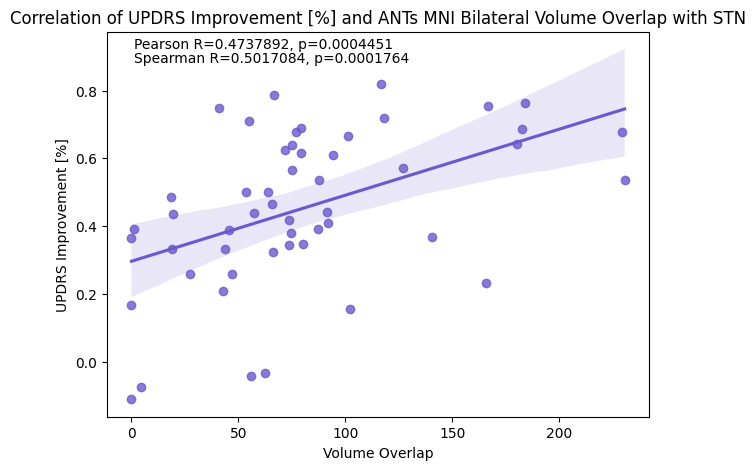

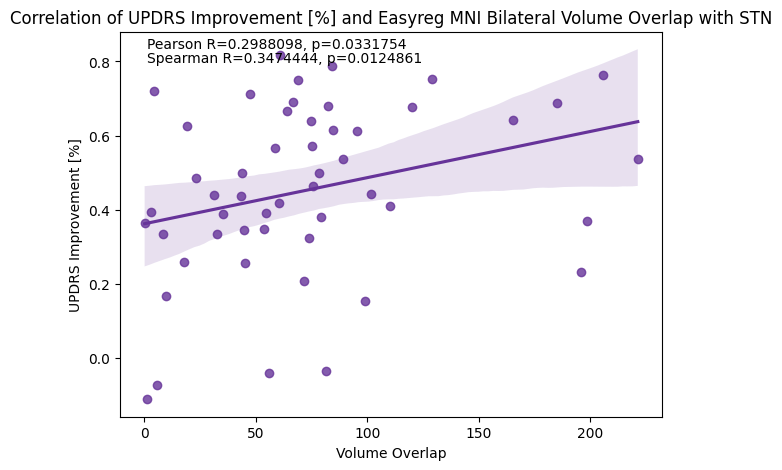

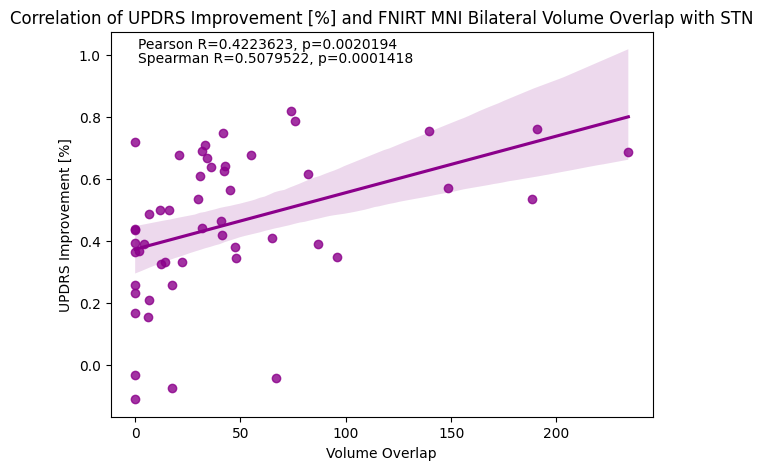

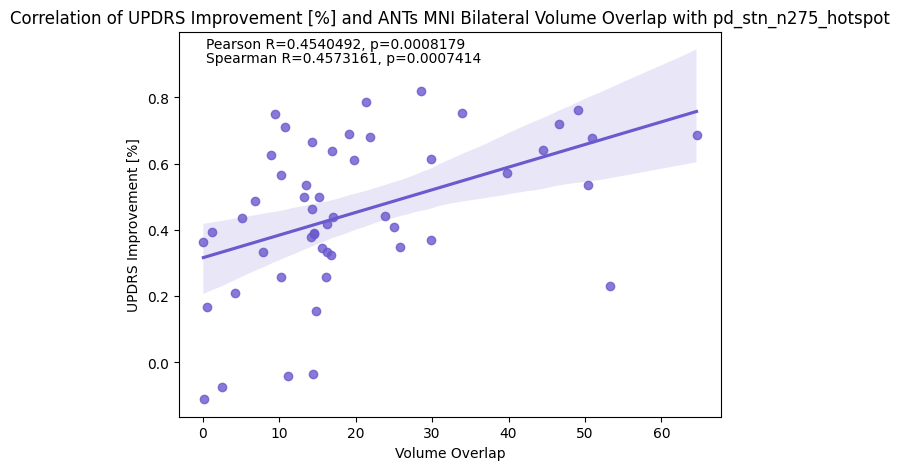

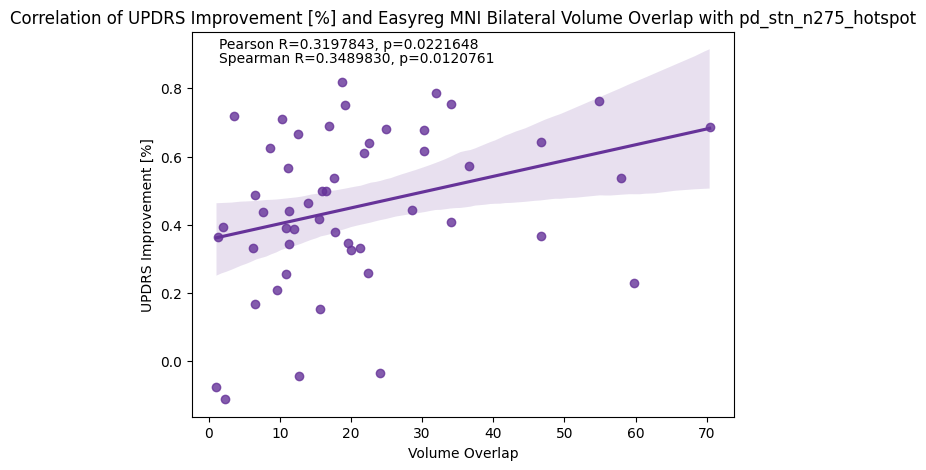

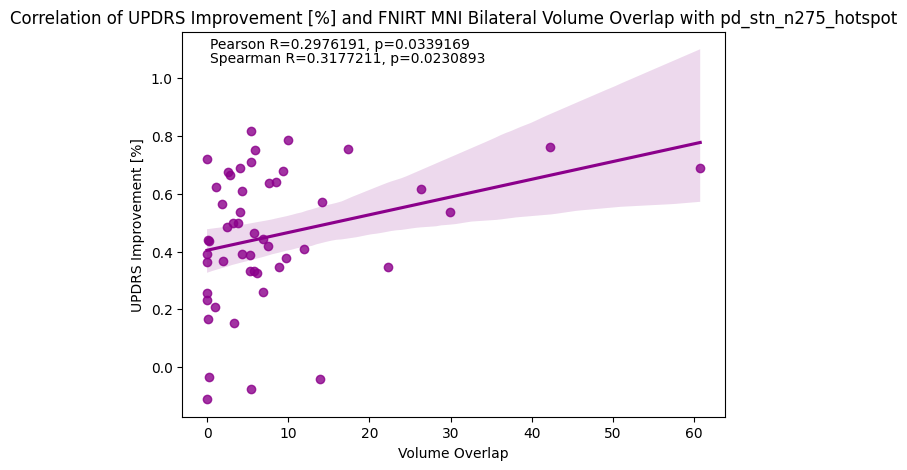

In [11]:
#oss-dbs: norm types
df = pd.read_csv('/Volumes/Cingulate/NativeMNI_Overlaps/Berlin51/CSV/OSS-DBS_Volume_Overlaps_NormTypes_MNI.csv')
regions = ['STN','pd_stn_n275_hotspot']
norm = ['ANTs','Easyreg','FNIRT']
colors = ['slateblue','rebeccapurple','darkmagenta']
color_index = 0

def r_p(vol_overlap_col):
    pearson_r, pearson_p = pearsonr(df['UPDRS_Improvement_Perc'],df[vol_overlap_col])
    spearman_r, spearman_p = spearmanr(df['UPDRS_Improvement_Perc'],df[vol_overlap_col])
    return pearson_r, pearson_p, spearman_r, spearman_p

def plot_analysis(x_data, title, pearson_r_val, pearson_p_val, spearman_r_val, spearman_p_val, color,path):
    plt.figure(figsize=(7, 5))
    ax = sns.regplot(x=x_data, y=df['UPDRS_Improvement_Perc'], color=color)
    plt.title(title)
    plt.xlabel('Volume Overlap')
    plt.ylabel('UPDRS Improvement [%]')
    ax.text(0.05, 0.95, 'Pearson R={:.7f}, p={:.7f}'.format(pearson_r_val, pearson_p_val),transform=ax.transAxes, verticalalignment='bottom')
    ax.text(0.05, 0.95, 'Spearman R={:.7f}, p={:.7f}'.format(spearman_r_val, spearman_p_val),transform=ax.transAxes, verticalalignment='top')
    plt.savefig(path)
    plt.show()
    
for r in regions:
    for n in norm:
        c = colors[color_index % len(colors)]
        mni_pearson_r,mni_pearson_p,mni_spearman_r,mni_spearman_p = r_p(f'{n}_{r}_MNI_Overlap_BI_MM')
        plot_analysis(df[f'{n}_{r}_MNI_Overlap_BI_MM'],f'Correlation of UPDRS Improvement [%] and {n} MNI Bilateral Volume Overlap with {r}',mni_pearson_r,mni_pearson_p,mni_spearman_r,mni_spearman_p,c,f'/Volumes/Cingulate/NativeMNI_Overlaps/Berlin51/Figures/OSS-DBS/{n} MNI Correlation Bilateral Volume Overlap with {r}.png')
        color_index += 1

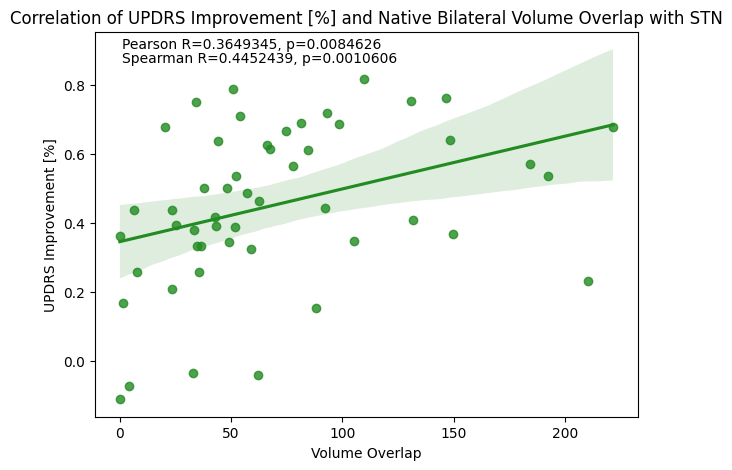

In [11]:
#oss-dbs: native
df = pd.read_csv('/Volumes/Cingulate/NativeMNI_Overlaps/Berlin51/CSV/OSS-DBS_Volume_Overlaps_STN_Native.csv')
regions = ['STN']

def r_p(vol_overlap_col):
    pearson_r, pearson_p = pearsonr(df['UPDRS_Improvement_Perc'],df[vol_overlap_col])
    spearman_r, spearman_p = spearmanr(df['UPDRS_Improvement_Perc'],df[vol_overlap_col])
    return pearson_r, pearson_p, spearman_r, spearman_p

def plot_analysis(x_data, title, pearson_r_val, pearson_p_val, spearman_r_val, spearman_p_val, color,path):
    plt.figure(figsize=(7, 5))
    ax = sns.regplot(x=x_data, y=df['UPDRS_Improvement_Perc'], color=color)
    plt.title(title)
    plt.xlabel('Volume Overlap')
    plt.ylabel('UPDRS Improvement [%]')
    ax.text(0.05, 0.95, 'Pearson R={:.7f}, p={:.7f}'.format(pearson_r_val, pearson_p_val),transform=ax.transAxes, verticalalignment='bottom')
    ax.text(0.05, 0.95, 'Spearman R={:.7f}, p={:.7f}'.format(spearman_r_val, spearman_p_val),transform=ax.transAxes, verticalalignment='top')
    plt.savefig(path)
    plt.show()
    
for r in regions:
    native_pearson_r,native_pearson_p,native_spearman_r,native_spearman_p = r_p(f'STN_Manual_Native_Overlap_BI_MM')
    plot_analysis(df[f'STN_Manual_Native_Overlap_BI_MM'],f'Correlation of UPDRS Improvement [%] and Native Bilateral Volume Overlap with {r}',native_pearson_r,native_pearson_p,native_spearman_r,native_spearman_p,'forestgreen',f'/Volumes/Cingulate/NativeMNI_Overlaps/Berlin51/Figures/OSS-DBS/Native-Native2 Correlation Bilateral Volume Overlap with {r}.png')

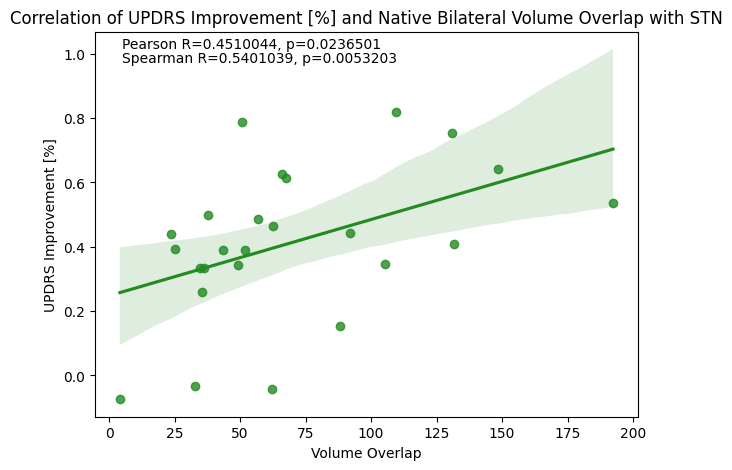

In [12]:
#oss-dbs: native 1-25
df = pd.read_csv('/Volumes/Cingulate/NativeMNI_Overlaps/Berlin51/CSV/OSS-DBS_Volume_Overlaps_STN_Native1-25.csv')
regions = ['STN']

def r_p(vol_overlap_col):
    pearson_r, pearson_p = pearsonr(df['UPDRS_Improvement_Perc'],df[vol_overlap_col])
    spearman_r, spearman_p = spearmanr(df['UPDRS_Improvement_Perc'],df[vol_overlap_col])
    return pearson_r, pearson_p, spearman_r, spearman_p

def plot_analysis(x_data, title, pearson_r_val, pearson_p_val, spearman_r_val, spearman_p_val, color,path):
    plt.figure(figsize=(7, 5))
    ax = sns.regplot(x=x_data, y=df['UPDRS_Improvement_Perc'], color=color)
    plt.title(title)
    plt.xlabel('Volume Overlap')
    plt.ylabel('UPDRS Improvement [%]')
    ax.text(0.05, 0.95, 'Pearson R={:.7f}, p={:.7f}'.format(pearson_r_val, pearson_p_val),transform=ax.transAxes, verticalalignment='bottom')
    ax.text(0.05, 0.95, 'Spearman R={:.7f}, p={:.7f}'.format(spearman_r_val, spearman_p_val),transform=ax.transAxes, verticalalignment='top')
    #plt.savefig(path)
    plt.show()
    
for r in regions:
    native_pearson_r,native_pearson_p,native_spearman_r,native_spearman_p = r_p(f'STN_Manual_Native_Overlap_BI_MM')
    plot_analysis(df[f'STN_Manual_Native_Overlap_BI_MM'],f'Correlation of UPDRS Improvement [%] and Native Bilateral Volume Overlap with {r}',native_pearson_r,native_pearson_p,native_spearman_r,native_spearman_p,'forestgreen',f'/Volumes/Cingulate/NativeMNI_Overlaps/Berlin51/Figures/OSS-DBS/Native-Native2 Correlation Bilateral Volume Overlap with {r}.png')

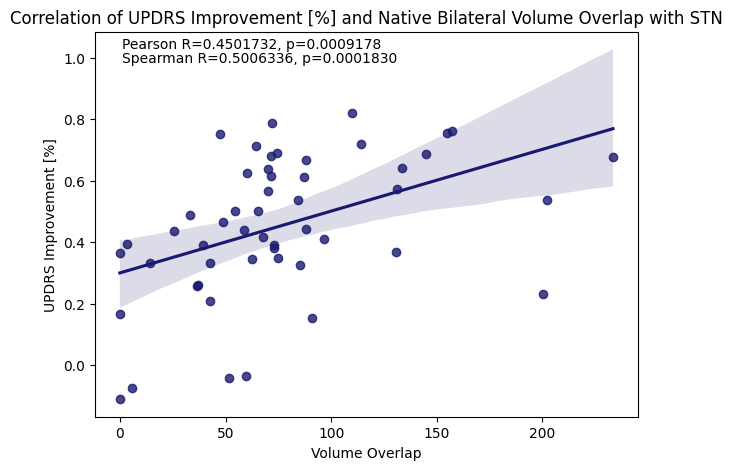

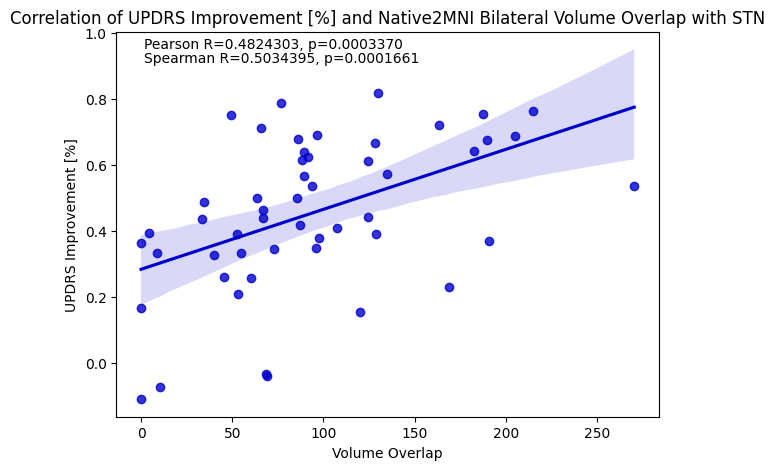

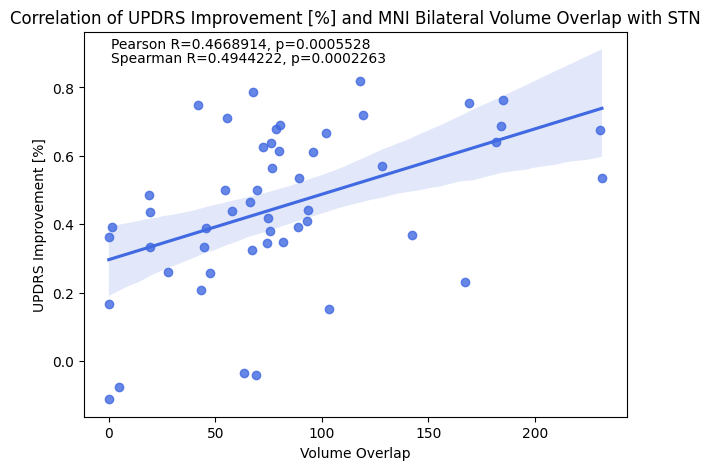

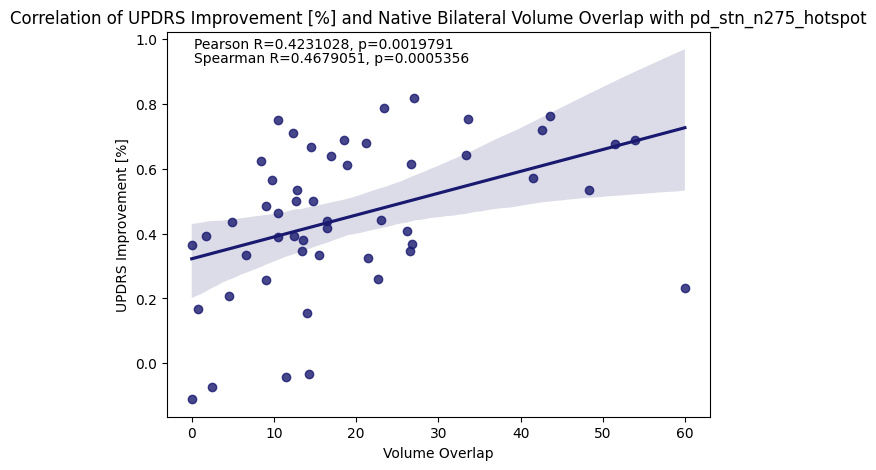

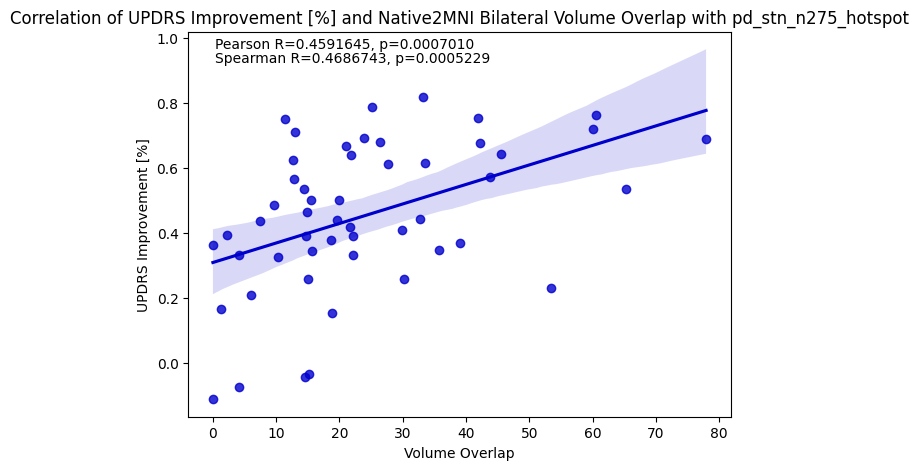

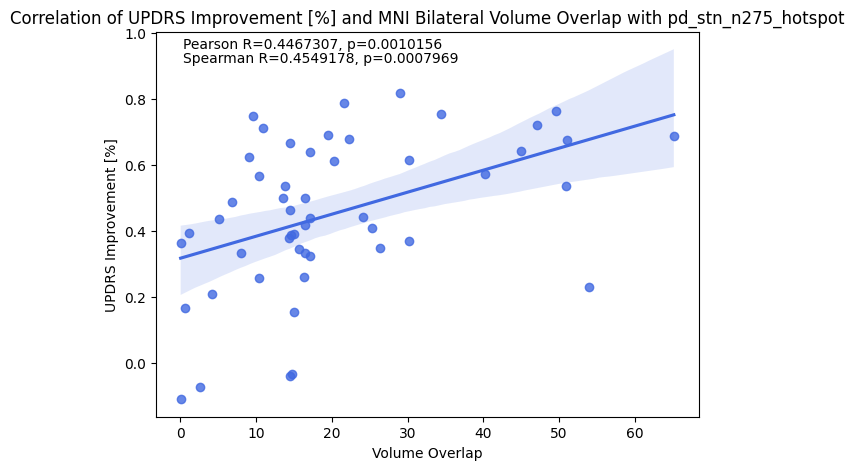

In [12]:
#oss-dbs
df = pd.read_csv('/Volumes/Cingulate/NativeMNI_Overlaps/Berlin51/OSS-DBS_Volume_Overlaps.csv')
regions = ['STN','pd_stn_n275_hotspot']

def r_p(vol_overlap_col):
    pearson_r, pearson_p = pearsonr(df['UPDRS_Improvement_Perc'],df[vol_overlap_col])
    spearman_r, spearman_p = spearmanr(df['UPDRS_Improvement_Perc'],df[vol_overlap_col])
    return pearson_r, pearson_p, spearman_r, spearman_p

def plot_analysis(x_data, title, pearson_r_val, pearson_p_val, spearman_r_val, spearman_p_val, color,path):
    plt.figure(figsize=(7, 5))
    ax = sns.regplot(x=x_data, y=df['UPDRS_Improvement_Perc'], color=color)
    plt.title(title)
    plt.xlabel('Volume Overlap')
    plt.ylabel('UPDRS Improvement [%]')
    ax.text(0.05, 0.95, 'Pearson R={:.7f}, p={:.7f}'.format(pearson_r_val, pearson_p_val),transform=ax.transAxes, verticalalignment='bottom')
    ax.text(0.05, 0.95, 'Spearman R={:.7f}, p={:.7f}'.format(spearman_r_val, spearman_p_val),transform=ax.transAxes, verticalalignment='top')
    plt.savefig(path)
    plt.show()
    
for r in regions:
    native_pearson_r,native_pearson_p,native_spearman_r,native_spearman_p = r_p(f'{r}_Native_Overlap_BI_MM')
    native2mni_pearson_r,native2mni_pearson_p,native2mni_spearman_r,native2mni_spearman_p = r_p(f'{r}_Native2MNI_Overlap_BI_MM')
    mni_pearson_r,mni_pearson_p,mni_spearman_r,mni_spearman_p = r_p(f'{r}_MNI_Overlap_BI_MM')
    plot_analysis(df[f'{r}_Native_Overlap_BI_MM'],f'Correlation of UPDRS Improvement [%] and Native Bilateral Volume Overlap with {r}',native_pearson_r,native_pearson_p,native_spearman_r,native_spearman_p,'midnightblue',f'/Volumes/Cingulate/NativeMNI_Overlaps/Berlin51/Figures/OSS-DBS/Native Correlation Bilateral Volume Overlap with {r}.png')
    plot_analysis(df[f'{r}_Native2MNI_Overlap_BI_MM'],f'Correlation of UPDRS Improvement [%] and Native2MNI Bilateral Volume Overlap with {r}',native2mni_pearson_r,native2mni_pearson_p,native2mni_spearman_r,native2mni_spearman_p,'mediumblue',f'/Volumes/Cingulate/NativeMNI_Overlaps/Berlin51/Figures/OSS-DBS/Native2MNI Correlation Bilateral Volume Overlap with {r}.png')
    plot_analysis(df[f'{r}_MNI_Overlap_BI_MM'],f'Correlation of UPDRS Improvement [%] and MNI Bilateral Volume Overlap with {r}',mni_pearson_r,mni_pearson_p,mni_spearman_r,mni_spearman_p,'royalblue',f'/Volumes/Cingulate/NativeMNI_Overlaps/Berlin51/Figures/OSS-DBS/MNI Correlation Bilateral Volume Overlap with {r}.png')

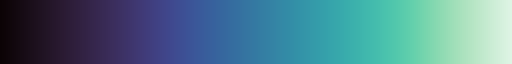

In [87]:
sns.color_palette("mako", as_cmap=True)

# FieldTrip Plots

/var/folders/wf/8pxjw4251t7fl_l85_v1_33r0000gp/T/ipykernel_18627/3994011178.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Column', y='Value', data=melted_df,palette='crest')


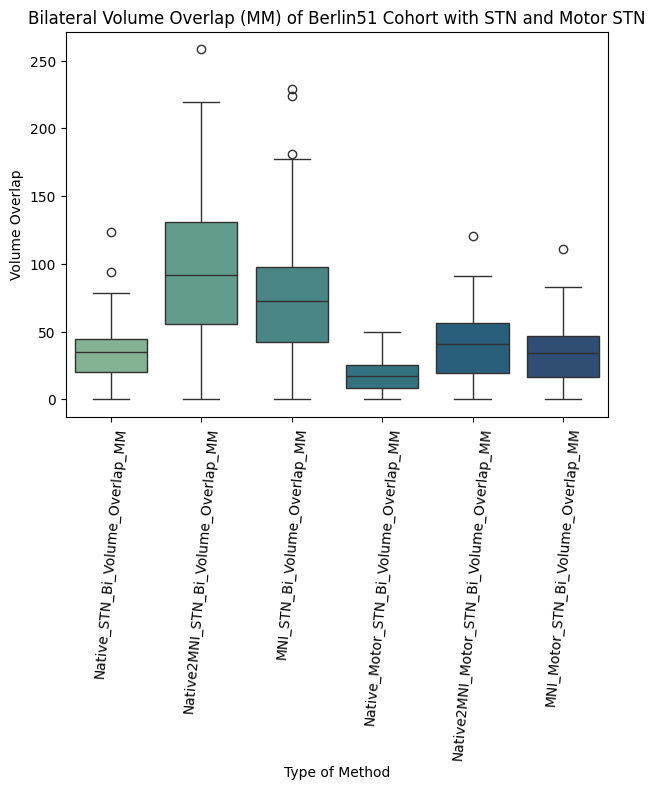

/var/folders/wf/8pxjw4251t7fl_l85_v1_33r0000gp/T/ipykernel_18627/3994011178.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Column', y='Value', data=melted_df,palette='crest')


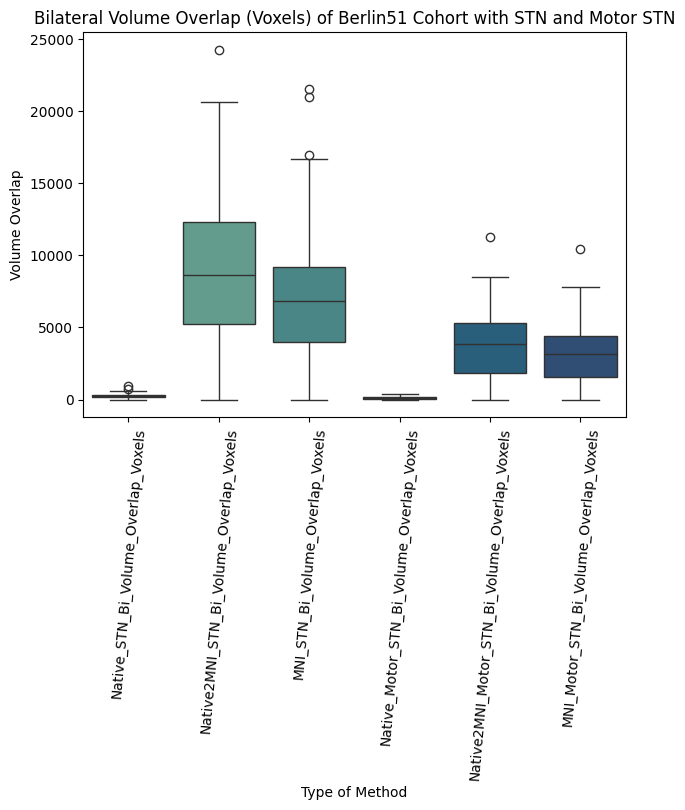

/var/folders/wf/8pxjw4251t7fl_l85_v1_33r0000gp/T/ipykernel_18627/3994011178.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Column', y='Value', data=melted_df,palette='crest')


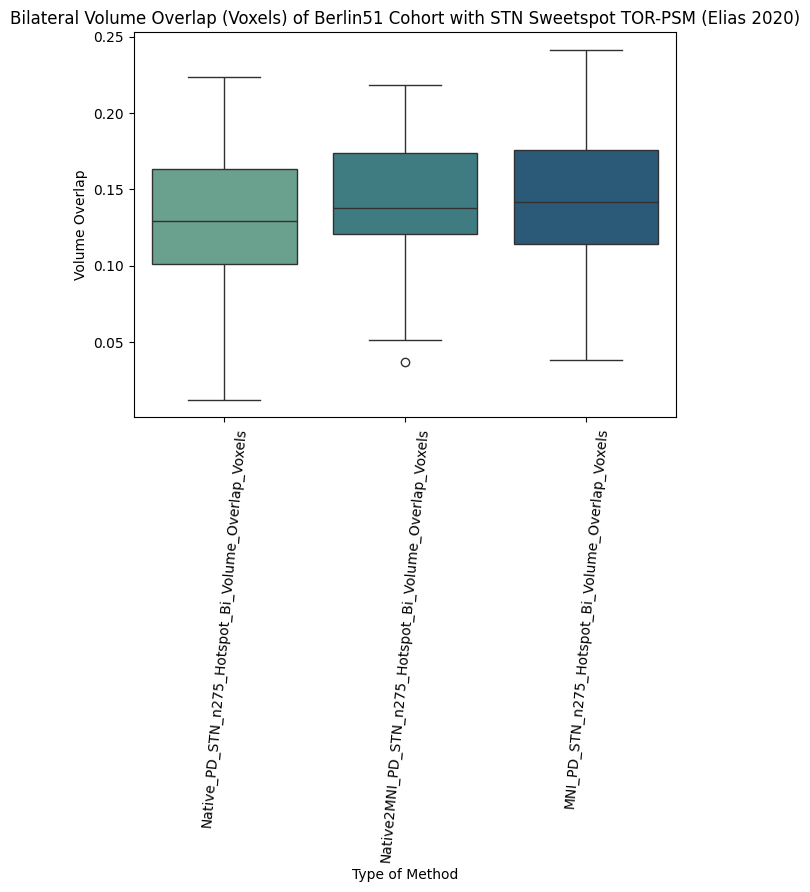

/var/folders/wf/8pxjw4251t7fl_l85_v1_33r0000gp/T/ipykernel_18627/3994011178.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Column', y='Value', data=melted_df,palette='crest')


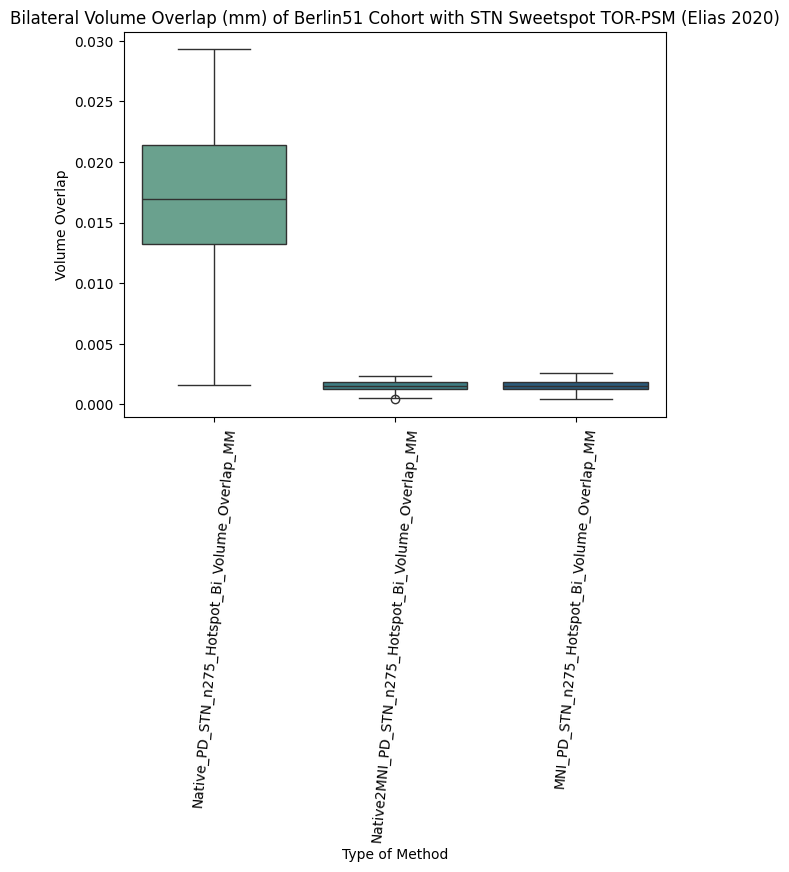

In [21]:
#plotting bilateral overlap with STNs, and Hotspots
def plot_overlap(columns_to_include,title):
    df = pd.read_csv('/Volumes/Cingulate/NativeMNI_Overlaps/Berlin51/FieldTrip_Berlin51_Overlap.csv')
    selected_df = df[columns_to_include]
    melted_df = selected_df.melt(var_name='Column', value_name='Value')

    plt.figure(figsize=(7, 5))
    ax = sns.boxplot(x='Column', y='Value', data=melted_df,palette='crest')
    ax.set(xlabel = 'Type of Method',ylabel='Volume Overlap',title=title)
    ax.tick_params(axis='x', rotation=85)
    plt.show()
    
plot_overlap((['Native_STN_Bi_Volume_Overlap_MM', 'Native2MNI_STN_Bi_Volume_Overlap_MM','MNI_STN_Bi_Volume_Overlap_MM','Native_Motor_STN_Bi_Volume_Overlap_MM', 'Native2MNI_Motor_STN_Bi_Volume_Overlap_MM','MNI_Motor_STN_Bi_Volume_Overlap_MM']),'Bilateral Volume Overlap (MM) of Berlin51 Cohort with STN and Motor STN')
plot_overlap((['Native_STN_Bi_Volume_Overlap_Voxels', 'Native2MNI_STN_Bi_Volume_Overlap_Voxels','MNI_STN_Bi_Volume_Overlap_Voxels','Native_Motor_STN_Bi_Volume_Overlap_Voxels', 'Native2MNI_Motor_STN_Bi_Volume_Overlap_Voxels','MNI_Motor_STN_Bi_Volume_Overlap_Voxels']),'Bilateral Volume Overlap (Voxels) of Berlin51 Cohort with STN and Motor STN')
plot_overlap((['Native_PD_STN_n275_Hotspot_Bi_Volume_Overlap_Voxels','Native2MNI_PD_STN_n275_Hotspot_Bi_Volume_Overlap_Voxels','MNI_PD_STN_n275_Hotspot_Bi_Volume_Overlap_Voxels']),'Bilateral Volume Overlap (Voxels) of Berlin51 Cohort with STN Sweetspot TOR-PSM (Elias 2020)')
plot_overlap((['Native_PD_STN_n275_Hotspot_Bi_Volume_Overlap_MM','Native2MNI_PD_STN_n275_Hotspot_Bi_Volume_Overlap_MM','MNI_PD_STN_n275_Hotspot_Bi_Volume_Overlap_MM']),'Bilateral Volume Overlap (mm) of Berlin51 Cohort with STN Sweetspot TOR-PSM (Elias 2020)')

In [29]:
#get r and p values for overlaps
def r_p(vol_overlap_col):
    df = pd.read_csv('/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/FieldTrip_Berlin51_Overlap.csv')
    pearson_r, pearson_p = pearsonr(df['UPDRS_Improvement_Perc'],df[vol_overlap_col])
    spearman_r, spearman_p = spearmanr(df['UPDRS_Improvement_Perc'],df[vol_overlap_col])
    return pearson_r, pearson_p, spearman_r, spearman_p

native_stn_pearson_r,native_stn_pearson_p,native_stn_spearman_r,native_stn_spearman_p = r_p('Native_STN_Bi_Volume_Overlap')
native2mni_stn_pearson_r,native2mni_stn_pearson_p,native2mni_stn_spearman_r,native2mni_stn_spearman_p = r_p('Native2MNI_STN_Bi_Volume_Overlap')
mni_stn_pearson_r,mni_stn_pearson_p,mni_stn_spearman_r,mni_stn_spearman_p = r_p('MNI_STN_Bi_Volume_Overlap')

native_motor_stn_pearson_r,native_motor_stn_pearson_p,native_motor_stn_spearman_r,native_motor_stn_spearman_p = r_p('Native_Motor_STN_Bi_Volume_Overlap')
native2mni_motor_stn_pearson_r,native2mni_motor_stn_pearson_p,native2mni_motor_stn_spearman_r,native2mni_motor_stn_spearman_p = r_p('Native2MNI_Motor_STN_Bi_Volume_Overlap')
mni_motor_stn_pearson_r,mni_motor_stn_pearson_p,mni_motor_stn_spearman_r,mni_motor_stn_spearman_p = r_p('MNI_Motor_STN_Bi_Volume_Overlap')

native_pd_pearson_r,native_pd_pearson_p,native_pd_spearman_r,native_pd_spearman_p = r_p('Native_PD_STN_n275_Hotspot_Bi_Volume_Overlap')
native2mni_pd_pearson_r,native2mni_pd_pearson_p,native2mni_pd_spearman_r,native2mni_pd_spearman_p = r_p('Native2MNI_PD_STN_n275_Hotspot_Bi_Volume_Overlap')
mni_pd_pearson_r,mni_pd_pearson_p,mni_pd_spearman_r,mni_pd_spearman_p = r_p('MNI_PD_STN_n275_Hotspot_Bi_Volume_Overlap')

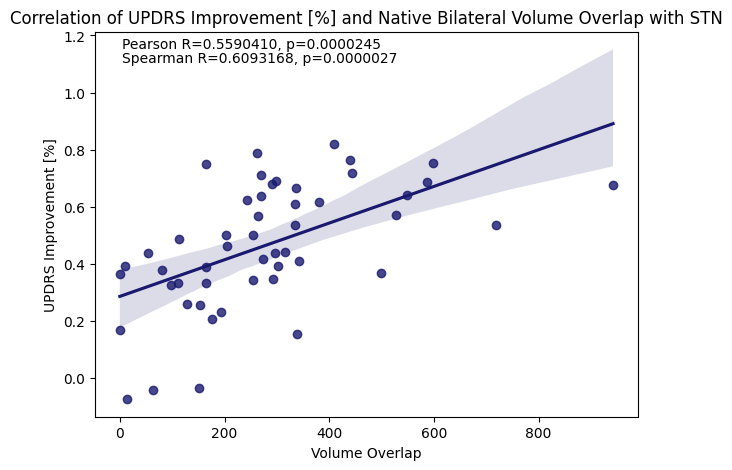

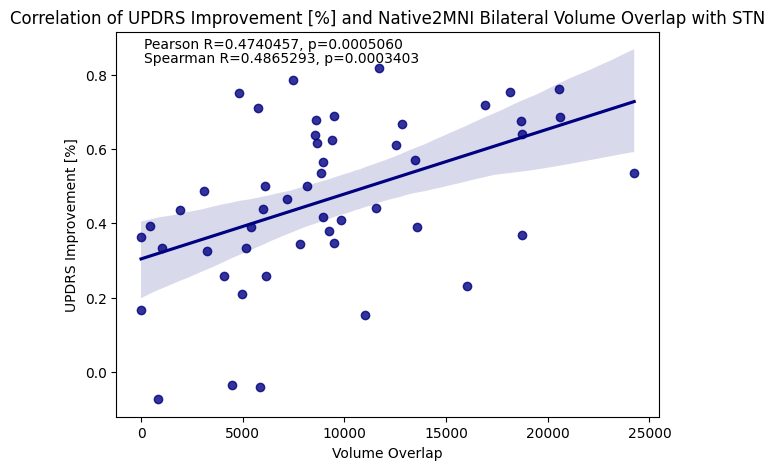

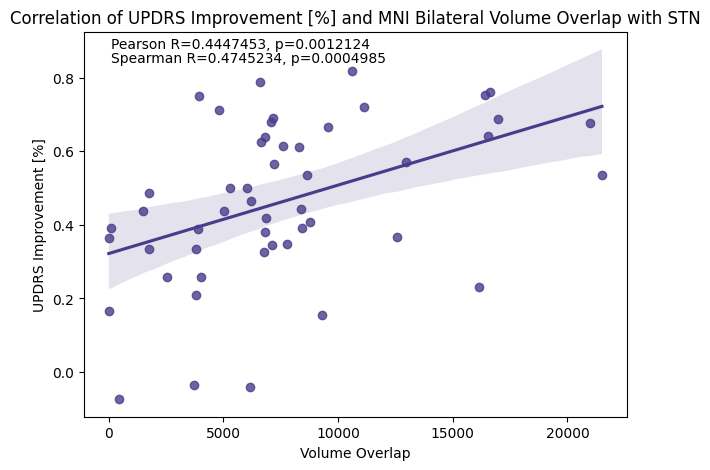

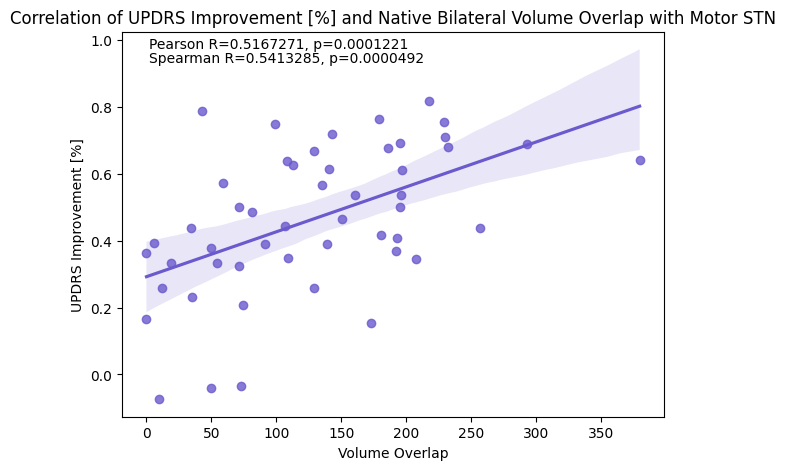

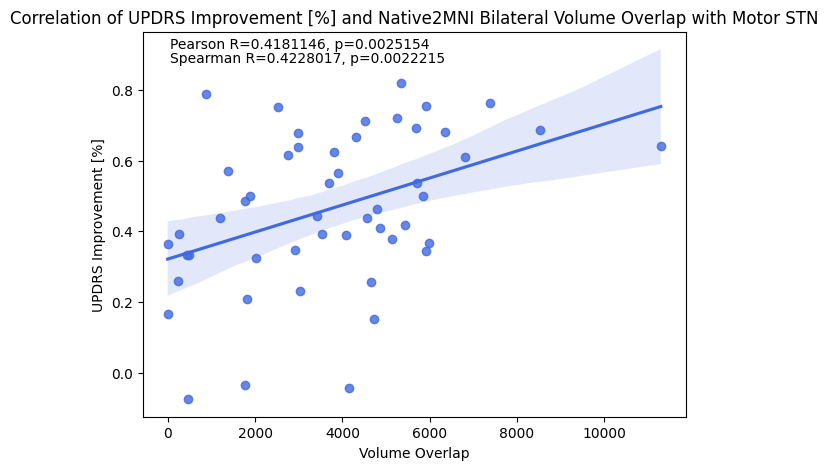

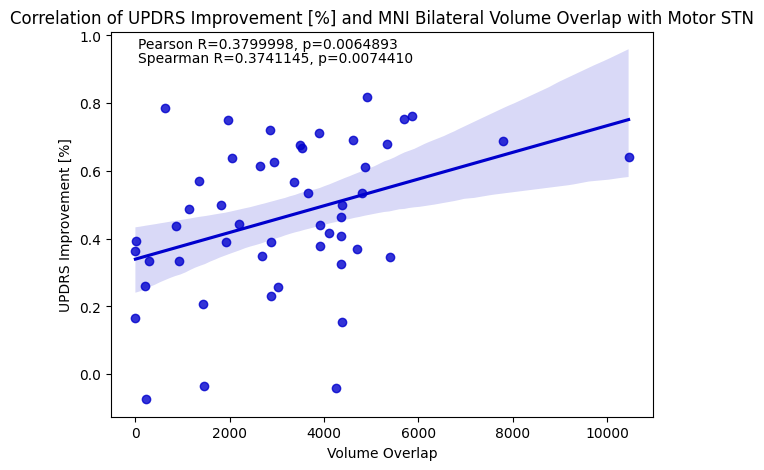

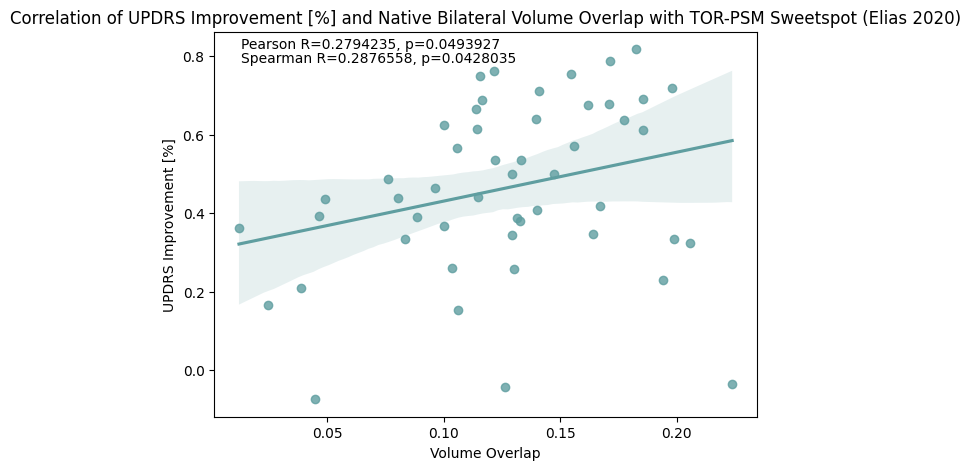

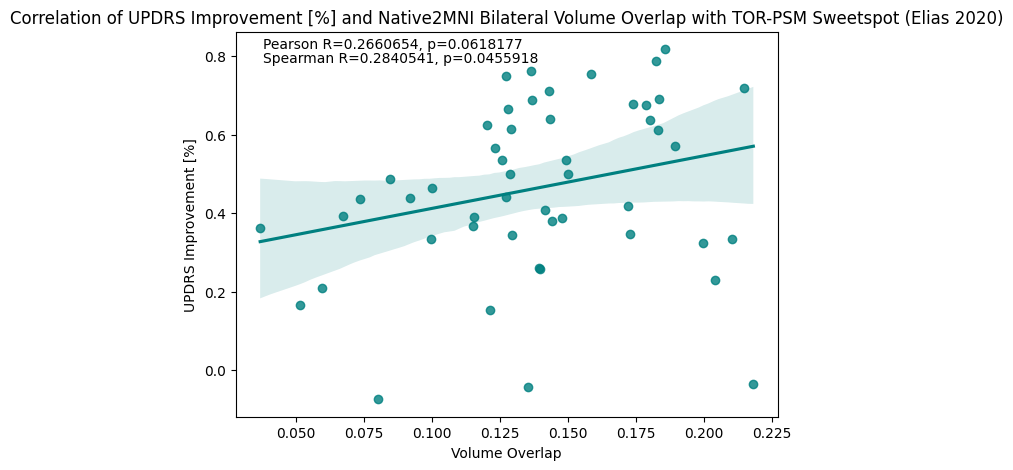

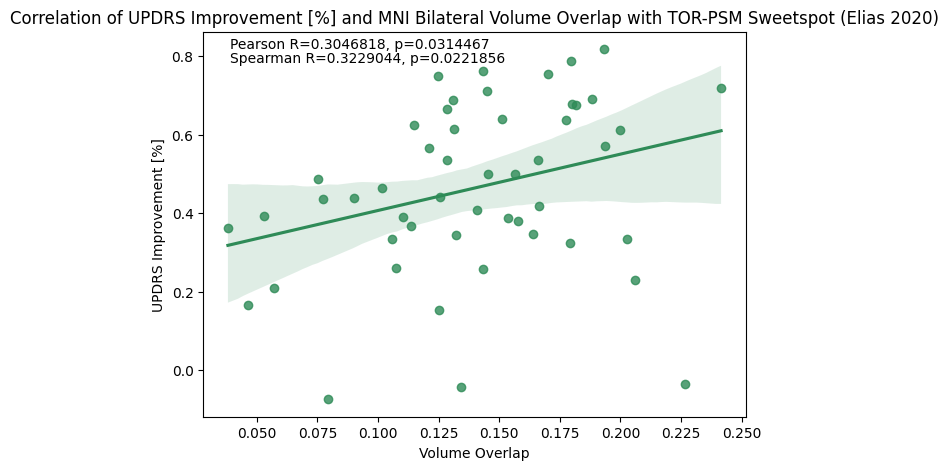

In [32]:
#correlation plots
def plot_analysis(x_data, title, pearson_r_val, pearson_p_val, spearman_r_val, spearman_p_val, color,path):
    plt.figure(figsize=(7, 5))
    ax = sns.regplot(x=x_data, y=df['UPDRS_Improvement_Perc'], color=color)
    plt.title(title)
    plt.xlabel('Volume Overlap')
    plt.ylabel('UPDRS Improvement [%]')
    ax.text(0.05, 0.95, 'Pearson R={:.7f}, p={:.7f}'.format(pearson_r_val, pearson_p_val),
            transform=ax.transAxes, verticalalignment='bottom')
    ax.text(0.05, 0.95, 'Spearman R={:.7f}, p={:.7f}'.format(spearman_r_val, spearman_p_val),
            transform=ax.transAxes, verticalalignment='top')
    plt.savefig(path)
    plt.show()

df = pd.read_csv('/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/FieldTrip_Berlin51_Overlap.csv')

plot_analysis(df['Native_STN_Bi_Volume_Overlap'],'Correlation of UPDRS Improvement [%] and Native Bilateral Volume Overlap with STN',native_stn_pearson_r,native_stn_pearson_p,native_stn_spearman_r,native_stn_spearman_p,'midnightblue','/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/Figures/FieldTrip/Native Bilateral Volume Overlap with STN.png')
plot_analysis(df['Native2MNI_STN_Bi_Volume_Overlap'],'Correlation of UPDRS Improvement [%] and Native2MNI Bilateral Volume Overlap with STN',native2mni_stn_pearson_r,native2mni_stn_pearson_p,native2mni_stn_spearman_r,native2mni_stn_spearman_p,'navy','/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/Figures/FieldTrip/Native2MNI Bilateral Volume Overlap with STN.png')
plot_analysis(df['MNI_STN_Bi_Volume_Overlap'],'Correlation of UPDRS Improvement [%] and MNI Bilateral Volume Overlap with STN',mni_stn_pearson_r,mni_stn_pearson_p,mni_stn_spearman_r,mni_stn_spearman_p,'darkslateblue','/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/Figures/FieldTrip/MNI Bilateral Volume Overlap with STN.png')

plot_analysis(df['Native_Motor_STN_Bi_Volume_Overlap'],'Correlation of UPDRS Improvement [%] and Native Bilateral Volume Overlap with Motor STN',native_motor_stn_pearson_r,native_motor_stn_pearson_p,native_motor_stn_spearman_r,native_motor_stn_spearman_p,'slateblue','/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/Figures/FieldTrip/Native Bilateral Volume Overlap with Motor STN.png')
plot_analysis(df['Native2MNI_Motor_STN_Bi_Volume_Overlap'],'Correlation of UPDRS Improvement [%] and Native2MNI Bilateral Volume Overlap with Motor STN',native2mni_motor_stn_pearson_r,native2mni_motor_stn_pearson_p,native2mni_motor_stn_spearman_r,native2mni_motor_stn_spearman_p,'royalblue','/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/Figures/FieldTrip/Native2MNI Bilateral Volume Overlap with Motor STN.png')
plot_analysis(df['MNI_Motor_STN_Bi_Volume_Overlap'],'Correlation of UPDRS Improvement [%] and MNI Bilateral Volume Overlap with Motor STN',mni_motor_stn_pearson_r,mni_motor_stn_pearson_p,mni_motor_stn_spearman_r,mni_motor_stn_spearman_p,'mediumblue','/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/Figures/FieldTrip/MNI Bilateral Volume Overlap with Motor STN.png')

plot_analysis(df['Native_PD_STN_n275_Hotspot_Bi_Volume_Overlap'],'Correlation of UPDRS Improvement [%] and Native Bilateral Volume Overlap with TOR-PSM Sweetspot (Elias 2020)',native_pd_pearson_r,native_pd_pearson_p,native_pd_spearman_r,native_pd_spearman_p,'cadetblue','/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/Figures/FieldTrip/Native Bilateral Volume Overlap with TOR-PSM Sweetspot (Elias 2020).png')
plot_analysis(df['Native2MNI_PD_STN_n275_Hotspot_Bi_Volume_Overlap'],'Correlation of UPDRS Improvement [%] and Native2MNI Bilateral Volume Overlap with TOR-PSM Sweetspot (Elias 2020)',native2mni_pd_pearson_r,native2mni_pd_pearson_p,native2mni_pd_spearman_r,native2mni_pd_spearman_p,'teal','/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/Figures/FieldTrip/Native2MNI Bilateral Volume Overlap with TOR-PSM Sweetspot (Elias 2020).png')
plot_analysis(df['MNI_PD_STN_n275_Hotspot_Bi_Volume_Overlap'],'Correlation of UPDRS Improvement [%] and MNI Bilateral Volume Overlap with TOR-PSM Sweetspot (Elias 2020)',mni_pd_pearson_r,mni_pd_pearson_p,mni_pd_spearman_r,mni_pd_spearman_p,'seagreen','/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/Figures/FieldTrip/MNI Bilateral Volume Overlap with TOR-PSM Sweetspot (Elias 2020).png')

In [3]:
#correlation of different method overlaps (native vs mni)
#get r and p values
def r_p(native,mni):
    df = pd.read_csv('/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/FieldTrip_Berlin51_Overlap.csv')
    pearson_r, pearson_p = pearsonr(df[native],df[mni])
    spearman_r, spearman_p = spearmanr(df[native],df[mni])
    return pearson_r, pearson_p, spearman_r, spearman_p

stn_pearson_r,stn_pearson_p,stn_spearman_r,stn_spearman_p = r_p('Native_STN_Bi_Volume_Overlap','MNI_STN_Bi_Volume_Overlap')
motor_stn_pearson_r,motor_stn_pearson_p,motor_stn_spearman_r,motor_stn_spearman_p = r_p('Native_Motor_STN_Bi_Volume_Overlap','MNI_Motor_STN_Bi_Volume_Overlap')
pd_pearson_r,pd_pearson_p,pd_spearman_r,pd_spearman_p = r_p('Native_PD_STN_n275_Hotspot_Bi_Volume_Overlap','MNI_PD_STN_n275_Hotspot_Bi_Volume_Overlap')

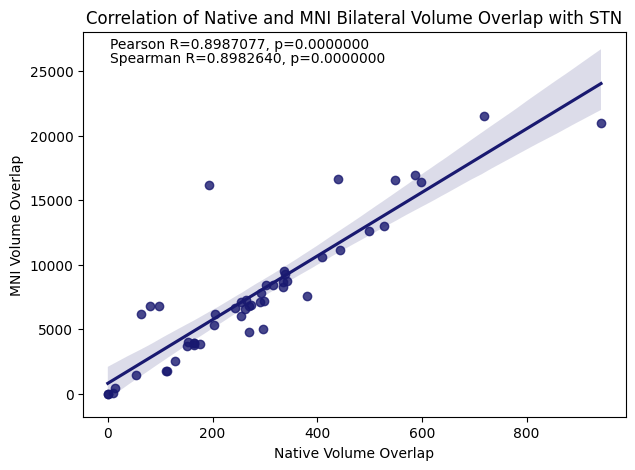

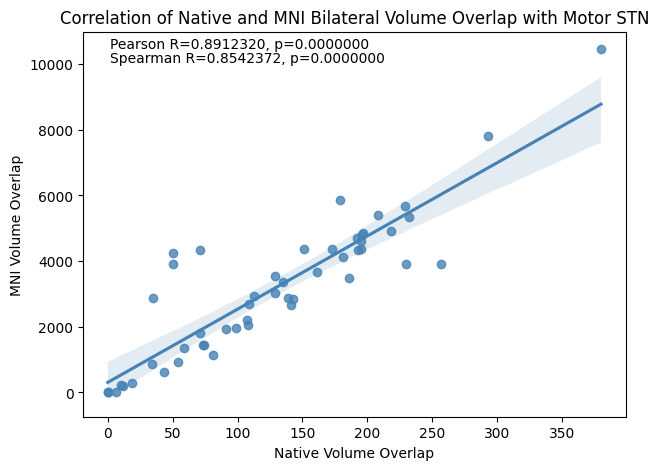

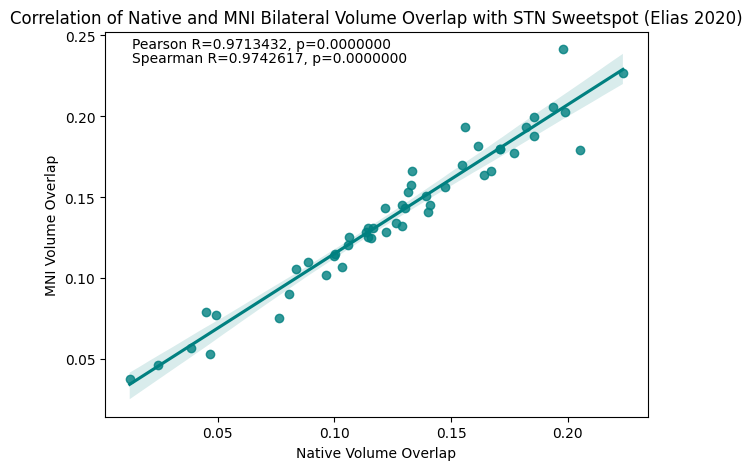

In [4]:
#correlation plots
def plot_analysis(x_data, y_data, title, pearson_r_val, pearson_p_val, spearman_r_val, spearman_p_val, color,path):
    plt.figure(figsize=(7, 5))
    ax = sns.regplot(x=x_data, y=y_data, color=color)
    plt.title(title)
    plt.xlabel('Native Volume Overlap')
    plt.ylabel('MNI Volume Overlap')
    ax.text(0.05, 0.95, 'Pearson R={:.7f}, p={:.7f}'.format(pearson_r_val, pearson_p_val),
            transform=ax.transAxes, verticalalignment='bottom')
    ax.text(0.05, 0.95, 'Spearman R={:.7f}, p={:.7f}'.format(spearman_r_val, spearman_p_val),
            transform=ax.transAxes, verticalalignment='top')
    plt.savefig(path)
    plt.show()

df = pd.read_csv('/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/FieldTrip_Berlin51_Overlap.csv')

plot_analysis(df['Native_STN_Bi_Volume_Overlap'],df['MNI_STN_Bi_Volume_Overlap'],'Correlation of Native and MNI Bilateral Volume Overlap with STN',stn_pearson_r,stn_pearson_p,stn_spearman_r,stn_spearman_p,'midnightblue','/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/Figures/FieldTrip/Native and MNI Bilateral Volume Overlap with STN Correlation.png')
plot_analysis(df['Native_Motor_STN_Bi_Volume_Overlap'],df['MNI_Motor_STN_Bi_Volume_Overlap'],'Correlation of Native and MNI Bilateral Volume Overlap with Motor STN',motor_stn_pearson_r,motor_stn_pearson_p,motor_stn_spearman_r,motor_stn_spearman_p,'steelblue','/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/Figures/FieldTrip/Native and MNI Bilateral Volume Overlap with Motor STN Correlation.png')
plot_analysis(df['Native_PD_STN_n275_Hotspot_Bi_Volume_Overlap'],df['MNI_PD_STN_n275_Hotspot_Bi_Volume_Overlap'],'Correlation of Native and MNI Bilateral Volume Overlap with STN Sweetspot (Elias 2020)',pd_pearson_r,pd_pearson_p,pd_spearman_r,pd_spearman_p,'teal','/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/Figures/FieldTrip/Native and MNI Bilateral Volume Overlap with STN Sweetspot (Elias 2020) Correlation.png')

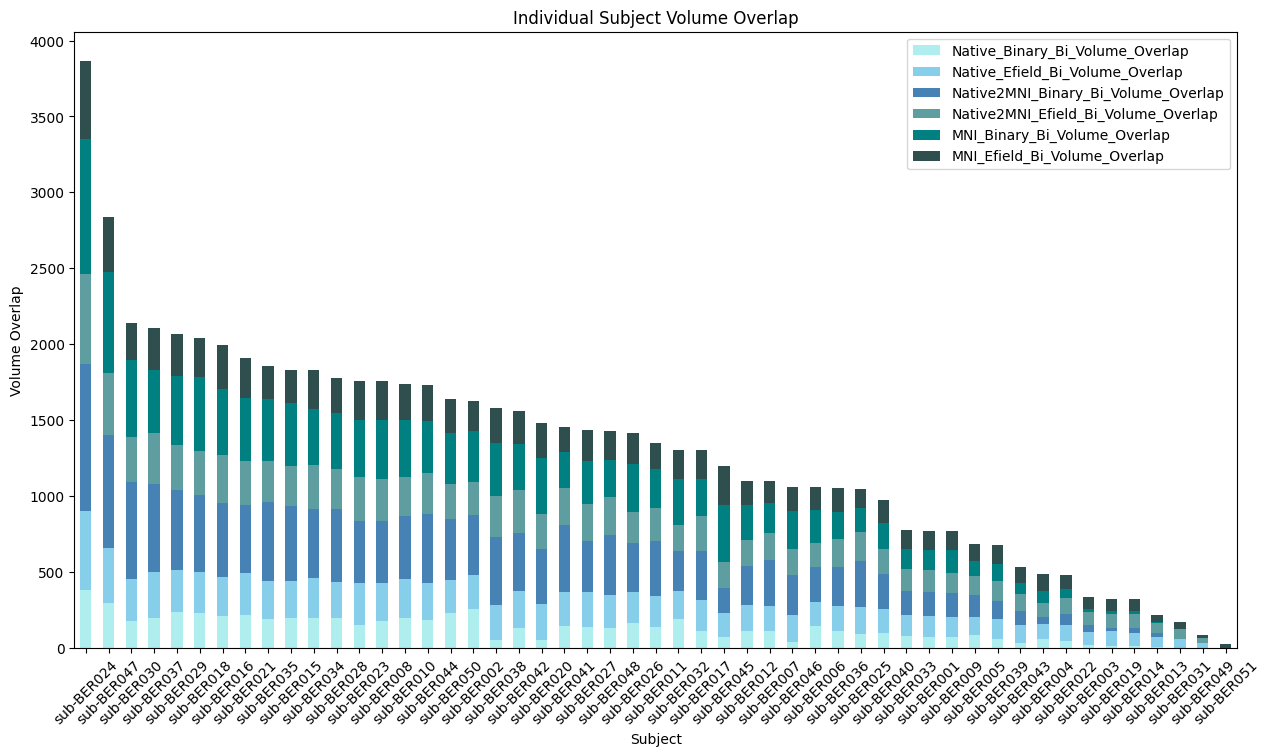

In [48]:
#old
columns_to_exclude = ['UPDRS_Improvement_Perc','Native_Binary_LH_Volume_Overlap','Native_Binary_RH_Volume_Overlap','Native_Efield_LH_Volume_Overlap','Native_Efield_RH_Volume_Overlap','Native2MNI_Binary_LH_Volume_Overlap','Native2MNI_Binary_RH_Volume_Overlap','Native2MNI_Efield_LH_Volume_Overlap','Native2MNI_Efield_RH_Volume_Overlap','MNI_Binary_LH_Volume_Overlap','MNI_Binary_RH_Volume_Overlap','MNI_Efield_LH_Volume_Overlap','MNI_Efield_RH_Volume_Overlap']
selected_df = df.drop(columns=columns_to_exclude)
sorted_df = selected_df.loc[selected_df.sum(axis=1).sort_values(ascending=False).index]

fig, ax = plt.subplots(figsize=(15, 8))

sorted_df.plot(kind='bar', stacked=True, color=['paleturquoise', 'skyblue', 'steelblue', 'cadetblue', 'teal', 'darkslategrey'], ax=ax)

plt.xticks(rotation=45)

plt.title('Individual Subject Volume Overlap')
plt.xlabel('Subject')
plt.ylabel('Volume Overlap')

plt.show()